# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-lc'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
        
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6065, Accuracy: 0.8198, F1 Micro: 0.122, F1 Macro: 0.0444
Epoch 2/10, Train Loss: 0.4617, Accuracy: 0.8278, F1 Micro: 0.0007, F1 Macro: 0.0003
Epoch 3/10, Train Loss: 0.3954, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3949, Accuracy: 0.8281, F1 Micro: 0.0036, F1 Macro: 0.0016
Epoch 5/10, Train Loss: 0.3769, Accuracy: 0.8324, F1 Micro: 0.0595, F1 Macro: 0.0247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3696, Accuracy: 0.8475, F1 Micro: 0.2419, F1 Macro: 0.0856
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3475, Accuracy: 0.8544, F1 Micro: 0.3196, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3336, Accuracy: 0.8698, F1 Micro: 0.4829, F1 Macro: 0.2106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2992, Accuracy: 0.8751, F1 Micro: 0.5435, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2712, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4826, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2828, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2566, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2346, Accuracy: 0.8339, F1 Micro: 0.0819, F1 Macro: 0.0335
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2073, Accuracy: 0.854, F1 Micro: 0.3367, F1 Macro: 0.1425
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1856, Accuracy: 0.8643, F1 Micro: 0.4734, F1 Macro: 0.2157
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1621, Accuracy: 0.8681, F1 Micro: 0.5673, F1 Macro: 0.2713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1536, Accuracy: 0.8705, F1 Micro: 0.596, F1 Macro: 0.3056
Epoch 9/10, Train Loss: 0.1377, Accuracy: 0.875, F1 Micro: 0.5474, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.404, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2235, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1982, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.8419, F1 Micro: 0.1912, F1 Macro: 0.072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.8638, F1 Micro: 0.5302, F1 Macro: 0.2434
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.8654, F1 Micro: 0.5291, F1 Macro: 0.2543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1156, Accuracy: 0.8688, F1 Micro: 0.5323, F1 Macro: 0.2603
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.8721, F1 Micro: 0.5299, F1 Macro: 0.2691
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0974, Accuracy: 0.8752, F1 Micro: 0.5465, F1 Macro: 0.2794
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3589, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.199, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.8603, F1 Micro: 0.4559, F1 Macro: 0.2076
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.8633, F1 Micro: 0.4507, F1 Macro: 0.2097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.8674, F1 Micro: 0.5818, F1 Macro: 0.2891
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.8759, F1 Micro: 0.5507, F1 Macro: 0.2809
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.8752, F1 Micro: 0.5701, F1 Macro: 0.3092
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.8758, F1 Micro: 0.6447, F1 Macro: 0.4336
Higher F1 achieved, saving model
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3377, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1964, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.8607, F1 Micro: 0.4536, F1 Macro: 0.2193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.8683, F1 Micro: 0.5908, F1 Macro: 0.2914
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.8773, F1 Micro: 0.6146, F1 Macro: 0.3163
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.8811, F1 Micro: 0.5975, F1 Macro: 0.3104
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.886, F1 Micro: 0.6245, F1 Macro: 0.3665
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.8857, F1 Micro: 0.6377, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3305, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2057, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.83, F1 Micro: 0.0259, F1 Macro: 0.0114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.848, F1 Micro: 0.2341, F1 Macro: 0.1085
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.8742, F1 Micro: 0.5091, F1 Macro: 0.2443
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.8826, F1 Micro: 0.6343, F1 Macro: 0.3355
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.8853, F1 Micro: 0.665, F1 Macro: 0.4203
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.8891, F1 Micro: 0.6671, F1 Macro: 0.4461
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.8913, F1 Micro: 0.6582, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.8587, F1 Micro: 0.3706, F1 Macro: 0.1745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.879, F1 Micro: 0.5543, F1 Macro: 0.2707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.8878, F1 Micro: 0.6283, F1 Macro: 0.3491
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.89, F1 Micro: 0.6776, F1 Macro: 0.4273
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.8963, F1 Micro: 0.6841, F1 Macro: 0.451
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.8885, F1 Micro: 0.688, F1 Macro: 0.4726
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.8963, F1 Micro: 0.6799, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3235, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.8313, F1 Micro: 0.0439, F1 Macro: 0.0185
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.8757, F1 Micro: 0.5202, F1 Macro: 0.249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.8875, F1 Micro: 0.6154, F1 Macro: 0.3577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.8943, F1 Micro: 0.6805, F1 Macro: 0.4369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.8934, F1 Micro: 0.6995, F1 Macro: 0.4787
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.8888, F1 Micro: 0.6936, F1 Macro: 0.4771
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.8973, F1 Micro: 0.6985, F1 Macro: 0.4885
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.8985, F1 Micro: 0.6979, F1 Macro: 0.489
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3396, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2534, Accuracy: 0.8683, F1 Micro: 0.4637, F1 Macro: 0.2301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.889, F1 Micro: 0.6555, F1 Macro: 0.4636
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.8952, F1 Micro: 0.6551, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.8978, F1 Micro: 0.7017, F1 Macro: 0.5124
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9028, F1 Micro: 0.7015, F1 Macro: 0.4814
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.8983, F1 Micro: 0.7082, F1 Macro: 0.5024
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9039, F1 Micro: 0.7116, F1 Macro: 0.5191
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9064, F1 Micro: 0.7184, F1 Macro: 0.5582
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.348, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.8745, F1 Micro: 0.5101, F1 Macro: 0.2638
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.8961, F1 Micro: 0.667, F1 Macro: 0.4422
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9028, F1 Micro: 0.6888, F1 Macro: 0.4889
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.8977, F1 Micro: 0.7084, F1 Macro: 0.5247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1098, Accuracy: 0.8983, F1 Micro: 0.7163, F1 Macro: 0.5464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9065, F1 Micro: 0.726, F1 Macro: 0.5507
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9059, F1 Micro: 0.7329, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2487, Accuracy: 0.8757, F1 Micro: 0.4952, F1 Macro: 0.314
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.894, F1 Micro: 0.6323, F1 Macro: 0.4685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9037, F1 Micro: 0.6797, F1 Macro: 0.5307
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9077, F1 Micro: 0.722, F1 Macro: 0.527
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9123, F1 Micro: 0.7278, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9146, F1 Micro: 0.7401, F1 Macro: 0.5862
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.914, F1 Micro: 0.7339, F1 Macro: 0.5849
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.9146, F1 Micro: 0.7239, F1 Macro: 0.5874
Higher F1 achieve

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8407, F1 Micro: 0.1637, F1 Macro: 0.0569
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.8902, F1 Micro: 0.6306, F1 Macro: 0.4485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.904, F1 Micro: 0.703, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9106, F1 Micro: 0.7188, F1 Macro: 0.5746
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9114, F1 Micro: 0.7097, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9119, F1 Micro: 0.7455, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9151, F1 Micro: 0.7489, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9164, F1 Micro: 0.7529, F1 Macro: 0.6064
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9136, F1 Micro: 0.7508, F1 Macro: 0.6079
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3743, Accuracy: 0.8438, F1 Micro: 0.1959, F1 Macro: 0.0685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.8949, F1 Micro: 0.6486, F1 Macro: 0.4561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9058, F1 Micro: 0.7181, F1 Macro: 0.5341
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9103, F1 Micro: 0.7386, F1 Macro: 0.5814
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9163, F1 Micro: 0.7385, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9155, F1 Micro: 0.7475, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9176, F1 Micro: 0.7516, F1 Macro: 0.5959
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9187, F1 Micro: 0.7508, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9169, F1 Micro: 0.7537, F1 Macro: 0.61
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8608, F1 Micro: 0.4006, F1 Macro: 0.1834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.8956, F1 Micro: 0.6532, F1 Macro: 0.4571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9081, F1 Micro: 0.721, F1 Macro: 0.5558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9124, F1 Micro: 0.7454, F1 Macro: 0.585
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9113, F1 Micro: 0.7444, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9185, F1 Micro: 0.7533, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9164, F1 Micro: 0.7612, F1 Macro: 0.6171
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9181, F1 Micro: 0.7573, F1 Macro: 0.6146
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9139, F1 Micro: 0.7576, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8714, F1 Micro: 0.5054, F1 Macro: 0.2415
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.8976, F1 Micro: 0.6608, F1 Macro: 0.4399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9099, F1 Micro: 0.7098, F1 Macro: 0.5421
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9122, F1 Micro: 0.7534, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9183, F1 Micro: 0.7551, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9195, F1 Micro: 0.7608, F1 Macro: 0.6085
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9126, F1 Micro: 0.7494, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9193, F1 Micro: 0.7615, F1 Macro: 0.618
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.9152, F1 Micro: 0.7605, F1 Macro: 0.6156
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3765, Accuracy: 0.8774, F1 Micro: 0.5876, F1 Macro: 0.29
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.899, F1 Micro: 0.6583, F1 Macro: 0.4264
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2057, Accuracy: 0.9087, F1 Micro: 0.703, F1 Macro: 0.5462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.917, F1 Micro: 0.7372, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9192, F1 Micro: 0.7552, F1 Macro: 0.6072
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9184, F1 Micro: 0.7549, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9165, F1 Micro: 0.7629, F1 Macro: 0.6191
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9193, F1 Micro: 0.761, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9191, F1 Micro: 0.7637, F1 Macro: 0.6097
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.8697, F1 Micro: 0.4509, F1 Macro: 0.2113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9002, F1 Micro: 0.6936, F1 Macro: 0.5312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.912, F1 Micro: 0.7138, F1 Macro: 0.5295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9143, F1 Micro: 0.7504, F1 Macro: 0.5946
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9188, F1 Micro: 0.7435, F1 Macro: 0.5883
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.92, F1 Micro: 0.7656, F1 Macro: 0.6169
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9196, F1 Micro: 0.7572, F1 Macro: 0.6161
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9203, F1 Micro: 0.7568, F1 Macro: 0.612
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9151, F1 Micro: 0.7583, F1 Macro: 0.6136
Epoch 10/10, Train Loss: 0.0636, Accuracy: 0.9195, F1 Micro: 0.7642, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3783, Accuracy: 0.8788, F1 Micro: 0.617, F1 Macro: 0.3093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9028, F1 Micro: 0.6914, F1 Macro: 0.4956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9117, F1 Micro: 0.718, F1 Macro: 0.5233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9176, F1 Micro: 0.7601, F1 Macro: 0.616
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9167, F1 Micro: 0.7582, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9204, F1 Micro: 0.7659, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9198, F1 Micro: 0.7676, F1 Macro: 0.6279
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9194, F1 Micro: 0.7634, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9224, F1 Micro: 0.7679, F1 Macro: 0.6275
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.8732, F1 Micro: 0.4826, F1 Macro: 0.232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.9013, F1 Micro: 0.6701, F1 Macro: 0.4431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9138, F1 Micro: 0.7318, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9173, F1 Micro: 0.7566, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9169, F1 Micro: 0.7572, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9227, F1 Micro: 0.7693, F1 Macro: 0.6259
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9241, F1 Micro: 0.7651, F1 Macro: 0.6239
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9215, F1 Micro: 0.7688, F1 Macro: 0.6285
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.917, F1 Micro: 0.7625, F1 Macro: 0.6275
Epoch 10/10, Train Loss: 0.0611, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8824, F1 Micro: 0.5839, F1 Macro: 0.2877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.905, F1 Micro: 0.7006, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.911, F1 Micro: 0.7341, F1 Macro: 0.5499
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9168, F1 Micro: 0.7345, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9202, F1 Micro: 0.7574, F1 Macro: 0.6145
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9226, F1 Micro: 0.7663, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.9199, F1 Micro: 0.7679, F1 Macro: 0.6364
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9203, F1 Micro: 0.7687, F1 Macro: 0.6467
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9211, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.8811, F1 Micro: 0.5661, F1 Macro: 0.2877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9041, F1 Micro: 0.6966, F1 Macro: 0.5179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.913, F1 Micro: 0.7401, F1 Macro: 0.5793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9201, F1 Micro: 0.7547, F1 Macro: 0.5998
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9198, F1 Micro: 0.7726, F1 Macro: 0.6232
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9215, F1 Micro: 0.7702, F1 Macro: 0.619
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9236, F1 Micro: 0.769, F1 Macro: 0.6292
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9229, F1 Micro: 0.7696, F1 Macro: 0.6347
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9218, F1 Micro: 0.7667, F1 Macro: 0.6354
Epoch 10/10, Train Loss: 0.0614, Accuracy: 0.9218, F1 Micro: 0.7679, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3765, Accuracy: 0.8801, F1 Micro: 0.5378, F1 Macro: 0.2631
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.9048, F1 Micro: 0.7077, F1 Macro: 0.5376
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.9133, F1 Micro: 0.7371, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9193, F1 Micro: 0.7456, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9222, F1 Micro: 0.7705, F1 Macro: 0.6229
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9213, F1 Micro: 0.7553, F1 Macro: 0.6237
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9175, F1 Micro: 0.7673, F1 Macro: 0.6367
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9217, F1 Micro: 0.7643, F1 Macro: 0.6382
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9198, F1 Micro: 0.7647, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0611, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3792, Accuracy: 0.8847, F1 Micro: 0.5986, F1 Macro: 0.3003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9025, F1 Micro: 0.6667, F1 Macro: 0.453
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9153, F1 Micro: 0.7494, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9169, F1 Micro: 0.7588, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9202, F1 Micro: 0.7679, F1 Macro: 0.6313
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9214, F1 Micro: 0.769, F1 Macro: 0.6414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9214, F1 Micro: 0.7714, F1 Macro: 0.638
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9164, F1 Micro: 0.764, F1 Macro: 0.6508
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9169, F1 Micro: 0.7625, F1 Macro: 0.6528
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8849, F1 Micro: 0.6437, F1 Macro: 0.3434
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.9065, F1 Micro: 0.7043, F1 Macro: 0.517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9121, F1 Micro: 0.7071, F1 Macro: 0.5194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9159, F1 Micro: 0.759, F1 Macro: 0.6134
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.919, F1 Micro: 0.759, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9208, F1 Micro: 0.7658, F1 Macro: 0.6286
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9231, F1 Micro: 0.7647, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9232, F1 Micro: 0.7715, F1 Macro: 0.6407
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9173, F1 Micro: 0.7594, F1 Macro: 0.6623
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3748, Accuracy: 0.8864, F1 Micro: 0.6089, F1 Macro: 0.3153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9068, F1 Micro: 0.6951, F1 Macro: 0.4985
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9149, F1 Micro: 0.743, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.916, F1 Micro: 0.7608, F1 Macro: 0.598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9173, F1 Micro: 0.7651, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9234, F1 Micro: 0.777, F1 Macro: 0.6462
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9221, F1 Micro: 0.7631, F1 Macro: 0.6337
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9201, F1 Micro: 0.7714, F1 Macro: 0.6377
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9189, F1 Micro: 0.7649, F1 Macro: 0.642
Epoch 10/10, Train Loss: 0.0608, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.8874, F1 Micro: 0.6385, F1 Macro: 0.3438
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.9032, F1 Micro: 0.7209, F1 Macro: 0.5231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.917, F1 Micro: 0.7418, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9196, F1 Micro: 0.7509, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.916, F1 Micro: 0.7557, F1 Macro: 0.6306
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9193, F1 Micro: 0.7663, F1 Macro: 0.6295
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9209, F1 Micro: 0.759, F1 Macro: 0.6514
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9187, F1 Micro: 0.7642, F1 Macro: 0.6698
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9199, F1 Micro: 0.7703, F1 Macro: 0.674
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.8888, F1 Micro: 0.6338, F1 Macro: 0.3408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.9051, F1 Micro: 0.6911, F1 Macro: 0.4616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9161, F1 Micro: 0.7466, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9175, F1 Micro: 0.765, F1 Macro: 0.6137
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9236, F1 Micro: 0.7594, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9227, F1 Micro: 0.7696, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9213, F1 Micro: 0.7676, F1 Macro: 0.6524
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9238, F1 Micro: 0.7697, F1 Macro: 0.6666
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9225, F1 Micro: 0.7675, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3766, Accuracy: 0.8838, F1 Micro: 0.5681, F1 Macro: 0.2756
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2496, Accuracy: 0.9078, F1 Micro: 0.6995, F1 Macro: 0.4994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.915, F1 Micro: 0.7329, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9211, F1 Micro: 0.7604, F1 Macro: 0.6182
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9257, F1 Micro: 0.7727, F1 Macro: 0.6621
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9183, F1 Micro: 0.7629, F1 Macro: 0.6577
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.924, F1 Micro: 0.7716, F1 Macro: 0.6588
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9225, F1 Micro: 0.7641, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9222, F1 Micro: 0.7753, F1 Macro: 0.6946
Higher F1 achieved, saving model
Epoch 1

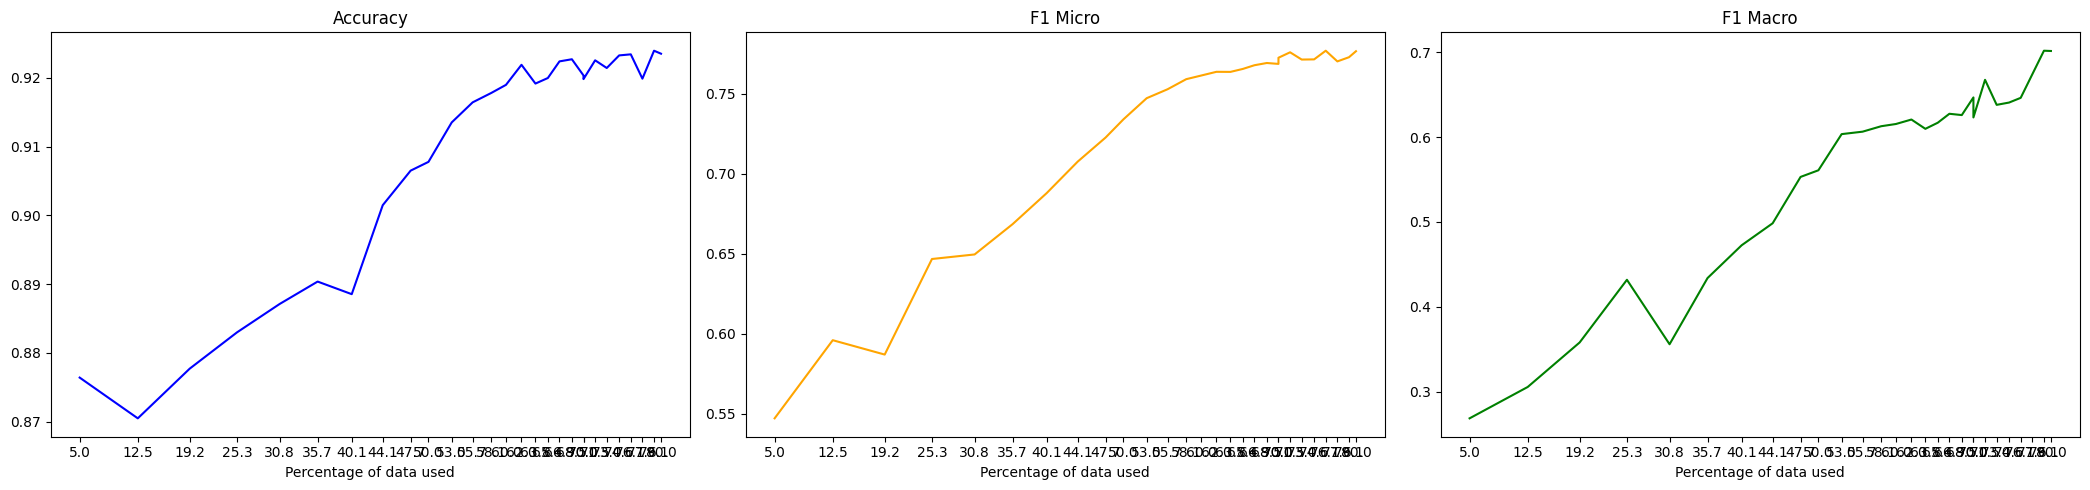

In [23]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5815, Accuracy: 0.8273, F1 Micro: 0.3943, F1 Macro: 0.1042
Epoch 2/10, Train Loss: 0.4544, Accuracy: 0.8345, F1 Micro: 0.2205, F1 Macro: 0.0565
Epoch 3/10, Train Loss: 0.4043, Accuracy: 0.8322, F1 Micro: 0.0793, F1 Macro: 0.0316
Epoch 4/10, Train Loss: 0.3672, Accuracy: 0.8369, F1 Micro: 0.1519, F1 Macro: 0.0501
Epoch 5/10, Train Loss: 0.3623, Accuracy: 0.8455, F1 Micro: 0.2415, F1 Macro: 0.0848
Epoch 6/10, Train Loss: 0.3367, Accuracy: 0.8517, F1 Micro: 0.3286, F1 Macro: 0.1153
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3235, Accuracy: 0.8681, F1 Micro: 0.4938, F1 Macro: 0.2278
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3035, Accuracy: 0.8719, F1 Micro: 0.5345, F1 Macro: 0.2502
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2634, Accuracy: 0.8738, F1 Micro: 0.5938, F1 Macro: 0.278
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2673, Accuracy: 0.8758, F1 Micro: 0.5957, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4532, Accuracy: 0.8278, F1 Micro: 0.0018, F1 Macro: 0.0007
Epoch 2/10, Train Loss: 0.2795, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2378, Accuracy: 0.8289, F1 Micro: 0.0143, F1 Macro: 0.0063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2074, Accuracy: 0.8496, F1 Micro: 0.2991, F1 Macro: 0.1041
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.179, Accuracy: 0.8689, F1 Micro: 0.5199, F1 Macro: 0.2418
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1638, Accuracy: 0.8722, F1 Micro: 0.5409, F1 Macro: 0.2538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1501, Accuracy: 0.8723, F1 Micro: 0.596, F1 Macro: 0.2765
Epoch 8/10, Train Loss: 0.1419, Accuracy: 0.8739, F1 Micro: 0.5327, F1 Macro: 0.2485
Epoch 9/10, Train Loss: 0.1249, Accuracy: 0.8771, F1 Micro: 0.5724, F1 Macro: 0.2672
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2169, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.8351, F1 Micro: 0.0986, F1 Macro: 0.0396
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.8641, F1 Micro: 0.4834, F1 Macro: 0.2169
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.8677, F1 Micro: 0.5644, F1 Macro: 0.2618
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.8695, F1 Micro: 0.5973, F1 Macro: 0.2762
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.874, F1 Micro: 0.5917, F1 Macro: 0.276
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0969, Accuracy: 0.8712, F1 Micro: 0.6003, F1 Macro: 0.2823
Epoch 9/10, Train Loss: 0.0916, Accuracy: 0.8778, F1 Micro: 0.5645, F1 Macro: 0.2684
Higher F1 achieved,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3456, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.205, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1849, Accuracy: 0.8327, F1 Micro: 0.0609, F1 Macro: 0.0255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.868, F1 Micro: 0.5053, F1 Macro: 0.2361
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.8747, F1 Micro: 0.5549, F1 Macro: 0.2589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.8754, F1 Micro: 0.6272, F1 Macro: 0.3049
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.8787, F1 Micro: 0.6283, F1 Macro: 0.3157
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.8824, F1 Micro: 0.6147, F1 Macro: 0.3261
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.8718, F1 Micro: 0.6511, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3218, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1968, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.8678, F1 Micro: 0.4575, F1 Macro: 0.217
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.8746, F1 Micro: 0.6301, F1 Macro: 0.2913
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.8753, F1 Micro: 0.6397, F1 Macro: 0.2972
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.8842, F1 Micro: 0.6266, F1 Macro: 0.3171
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.8815, F1 Micro: 0.6556, F1 Macro: 0.3531
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.8819, F1 Micro: 0.6583, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.319, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1969, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.8411, F1 Micro: 0.1511, F1 Macro: 0.0577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.8806, F1 Micro: 0.5895, F1 Macro: 0.2779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.8765, F1 Micro: 0.6437, F1 Macro: 0.3137
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.888, F1 Micro: 0.6436, F1 Macro: 0.3154
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.8862, F1 Micro: 0.6662, F1 Macro: 0.4009
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.8877, F1 Micro: 0.6673, F1 Macro: 0.4331
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.888, F1 Micro: 0.6782, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3188, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2148, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.8684, F1 Micro: 0.4394, F1 Macro: 0.2089
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.8874, F1 Micro: 0.6182, F1 Macro: 0.3427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.8925, F1 Micro: 0.6622, F1 Macro: 0.4166
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.8934, F1 Micro: 0.6594, F1 Macro: 0.4352
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.8949, F1 Micro: 0.6654, F1 Macro: 0.4542
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.8936, F1 Micro: 0.6758, F1 Macro: 0.4543
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.8985, F1 Micro: 0.6778, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3228, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2293, Accuracy: 0.8384, F1 Micro: 0.1264, F1 Macro: 0.0525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.8854, F1 Micro: 0.6232, F1 Macro: 0.3251
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.8847, F1 Micro: 0.6693, F1 Macro: 0.3927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.8966, F1 Micro: 0.6902, F1 Macro: 0.4639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.8981, F1 Micro: 0.6985, F1 Macro: 0.4807
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.8992, F1 Micro: 0.6904, F1 Macro: 0.4897
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.8972, F1 Micro: 0.7026, F1 Macro: 0.4948
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.898, F1 Micro: 0.697, F1 Macro: 0.5108
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3322, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.862, F1 Micro: 0.3872, F1 Macro: 0.188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.8892, F1 Micro: 0.6111, F1 Macro: 0.3381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.8976, F1 Micro: 0.6937, F1 Macro: 0.4946
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9003, F1 Micro: 0.6922, F1 Macro: 0.4807
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9014, F1 Micro: 0.6935, F1 Macro: 0.4873
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.8978, F1 Micro: 0.7065, F1 Macro: 0.4868
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9021, F1 Micro: 0.6844, F1 Macro: 0.5053
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9024, F1 Micro: 0.7075, F1 Macro: 0.5216
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3396, Accuracy: 0.8281, F1 Micro: 0.0047, F1 Macro: 0.0019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.8757, F1 Micro: 0.5122, F1 Macro: 0.2782
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.8956, F1 Micro: 0.6505, F1 Macro: 0.4204
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9045, F1 Micro: 0.7034, F1 Macro: 0.5287
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9038, F1 Micro: 0.6894, F1 Macro: 0.4807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9073, F1 Micro: 0.7057, F1 Macro: 0.532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9068, F1 Micro: 0.7176, F1 Macro: 0.5642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9098, F1 Micro: 0.7301, F1 Macro: 0.5753
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9131, F1 Micro: 0.7297, F1 Macro: 0.5705
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3439, Accuracy: 0.8348, F1 Micro: 0.092, F1 Macro: 0.0372
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.8817, F1 Micro: 0.5475, F1 Macro: 0.3418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1946, Accuracy: 0.9004, F1 Micro: 0.6697, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9062, F1 Micro: 0.7245, F1 Macro: 0.5729
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9061, F1 Micro: 0.7083, F1 Macro: 0.5693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9106, F1 Micro: 0.7255, F1 Macro: 0.5543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9117, F1 Micro: 0.7374, F1 Macro: 0.5798
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9139, F1 Micro: 0.7335, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9148, F1 Micro: 0.7437, F1 Macro: 0.5951
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3582, Accuracy: 0.8496, F1 Micro: 0.2838, F1 Macro: 0.1248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.8923, F1 Micro: 0.6465, F1 Macro: 0.4784
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.8987, F1 Micro: 0.6432, F1 Macro: 0.4626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9106, F1 Micro: 0.7103, F1 Macro: 0.543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9103, F1 Micro: 0.7426, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9125, F1 Micro: 0.7488, F1 Macro: 0.5977
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.914, F1 Micro: 0.7479, F1 Macro: 0.5956
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9131, F1 Micro: 0.7511, F1 Macro: 0.604
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9146, F1 Micro: 0.7476, F1 Macro: 0.6017
Epoch 10/10, Train Loss: 0.0573, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3596, Accuracy: 0.8579, F1 Micro: 0.3746, F1 Macro: 0.1767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.8967, F1 Micro: 0.6818, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9005, F1 Micro: 0.7136, F1 Macro: 0.5173
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9088, F1 Micro: 0.737, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9144, F1 Micro: 0.7405, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9154, F1 Micro: 0.7471, F1 Macro: 0.59
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.917, F1 Micro: 0.7403, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9188, F1 Micro: 0.7586, F1 Macro: 0.6069
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9182, F1 Micro: 0.7506, F1 Macro: 0.6045
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3602, Accuracy: 0.8623, F1 Micro: 0.4188, F1 Macro: 0.2
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.8973, F1 Micro: 0.6544, F1 Macro: 0.4739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.9044, F1 Micro: 0.6977, F1 Macro: 0.5512
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9109, F1 Micro: 0.7297, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9115, F1 Micro: 0.7423, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.916, F1 Micro: 0.756, F1 Macro: 0.6035
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9198, F1 Micro: 0.7516, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9177, F1 Micro: 0.7621, F1 Macro: 0.6081
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9192, F1 Micro: 0.7615, F1 Macro: 0.6175
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3679, Accuracy: 0.8652, F1 Micro: 0.4371, F1 Macro: 0.2101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8985, F1 Micro: 0.6716, F1 Macro: 0.4727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1982, Accuracy: 0.9067, F1 Micro: 0.6837, F1 Macro: 0.5237
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9146, F1 Micro: 0.7431, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9179, F1 Micro: 0.7514, F1 Macro: 0.6052
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9186, F1 Micro: 0.7404, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9195, F1 Micro: 0.7533, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9227, F1 Micro: 0.7639, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9215, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3651, Accuracy: 0.8739, F1 Micro: 0.5144, F1 Macro: 0.2523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2419, Accuracy: 0.901, F1 Micro: 0.6757, F1 Macro: 0.4805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9102, F1 Micro: 0.7166, F1 Macro: 0.556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9138, F1 Micro: 0.722, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.9195, F1 Micro: 0.7505, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9213, F1 Micro: 0.7664, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9167, F1 Micro: 0.7675, F1 Macro: 0.6178
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.9195, F1 Micro: 0.766, F1 Macro: 0.6142
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.9208, F1 Micro: 0.762, F1 Macro: 0.6191
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3674, Accuracy: 0.8736, F1 Micro: 0.4962, F1 Macro: 0.2408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.9017, F1 Micro: 0.6747, F1 Macro: 0.4415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9113, F1 Micro: 0.7111, F1 Macro: 0.5275
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9166, F1 Micro: 0.7513, F1 Macro: 0.5969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9151, F1 Micro: 0.7626, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9205, F1 Micro: 0.7665, F1 Macro: 0.6118
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9212, F1 Micro: 0.7535, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9213, F1 Micro: 0.7686, F1 Macro: 0.6225
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9175, F1 Micro: 0.7606, F1 Macro: 0.6137
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8756, F1 Micro: 0.515, F1 Macro: 0.2522
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2513, Accuracy: 0.903, F1 Micro: 0.688, F1 Macro: 0.4875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.9076, F1 Micro: 0.6884, F1 Macro: 0.5427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9151, F1 Micro: 0.7472, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9181, F1 Micro: 0.7626, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9217, F1 Micro: 0.7629, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9155, F1 Micro: 0.7641, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9227, F1 Micro: 0.766, F1 Macro: 0.6285
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9199, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3671, Accuracy: 0.8808, F1 Micro: 0.5534, F1 Macro: 0.2727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2436, Accuracy: 0.9055, F1 Micro: 0.7096, F1 Macro: 0.5131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9057, F1 Micro: 0.7354, F1 Macro: 0.5567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9182, F1 Micro: 0.7562, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9158, F1 Micro: 0.763, F1 Macro: 0.6149
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9194, F1 Micro: 0.756, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9236, F1 Micro: 0.772, F1 Macro: 0.6264
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9226, F1 Micro: 0.7693, F1 Macro: 0.6237
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9199, F1 Micro: 0.7704, F1 Macro: 0.6298
Epoch 10/10, Train Loss: 0.0626, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3713, Accuracy: 0.8848, F1 Micro: 0.6269, F1 Macro: 0.3225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9008, F1 Micro: 0.676, F1 Macro: 0.4559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9133, F1 Micro: 0.7378, F1 Macro: 0.5463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.918, F1 Micro: 0.7494, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9197, F1 Micro: 0.7611, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9156, F1 Micro: 0.7642, F1 Macro: 0.6118
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9202, F1 Micro: 0.7588, F1 Macro: 0.6224
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.918, F1 Micro: 0.7641, F1 Macro: 0.6174
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9215, F1 Micro: 0.7581, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3665, Accuracy: 0.8817, F1 Micro: 0.5582, F1 Macro: 0.2787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.9049, F1 Micro: 0.7077, F1 Macro: 0.5171
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.9151, F1 Micro: 0.7338, F1 Macro: 0.5693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.919, F1 Micro: 0.7604, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9219, F1 Micro: 0.7636, F1 Macro: 0.6176
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.9208, F1 Micro: 0.754, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9218, F1 Micro: 0.7713, F1 Macro: 0.6342
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.9186, F1 Micro: 0.7697, F1 Macro: 0.6314
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9228, F1 Micro: 0.7659, F1 Macro: 0.6339
Epoch 10/10, Train Loss: 0.0596, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3653, Accuracy: 0.8843, F1 Micro: 0.5677, F1 Macro: 0.289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2423, Accuracy: 0.9069, F1 Micro: 0.7058, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.9154, F1 Micro: 0.7413, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9135, F1 Micro: 0.7564, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9224, F1 Micro: 0.7712, F1 Macro: 0.6241
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9215, F1 Micro: 0.774, F1 Macro: 0.6289
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9213, F1 Micro: 0.7568, F1 Macro: 0.6274
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9209, F1 Micro: 0.7676, F1 Macro: 0.6437
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9202, F1 Micro: 0.769, F1 Macro: 0.647
Epoch 10/10, Train Loss: 0.0619, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3682, Accuracy: 0.8893, F1 Micro: 0.6371, F1 Macro: 0.3189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9085, F1 Micro: 0.7046, F1 Macro: 0.5081
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9142, F1 Micro: 0.7467, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9207, F1 Micro: 0.7587, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9256, F1 Micro: 0.7692, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9235, F1 Micro: 0.7727, F1 Macro: 0.6237
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9209, F1 Micro: 0.7701, F1 Macro: 0.6379
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9191, F1 Micro: 0.7644, F1 Macro: 0.6409
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9227, F1 Micro: 0.7713, F1 Macro: 0.6502
Epoch 10/10, Train Loss: 0.0607, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.8799, F1 Micro: 0.5274, F1 Macro: 0.2677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.9051, F1 Micro: 0.7124, F1 Macro: 0.5187
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9148, F1 Micro: 0.7488, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9185, F1 Micro: 0.7574, F1 Macro: 0.603
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9227, F1 Micro: 0.7569, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.9235, F1 Micro: 0.7642, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9241, F1 Micro: 0.7768, F1 Macro: 0.6366
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9219, F1 Micro: 0.775, F1 Macro: 0.6426
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9223, F1 Micro: 0.772, F1 Macro: 0.6536
Epoch 10/10, Train Loss: 0.0587, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3665, Accuracy: 0.8883, F1 Micro: 0.6388, F1 Macro: 0.3337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.9075, F1 Micro: 0.723, F1 Macro: 0.5198
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9147, F1 Micro: 0.7511, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9205, F1 Micro: 0.7616, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9247, F1 Micro: 0.7701, F1 Macro: 0.6281
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9237, F1 Micro: 0.7725, F1 Macro: 0.6341
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9244, F1 Micro: 0.7693, F1 Macro: 0.6394
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9232, F1 Micro: 0.7672, F1 Macro: 0.6356
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9212, F1 Micro: 0.7574, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.887, F1 Micro: 0.6547, F1 Macro: 0.3609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.9095, F1 Micro: 0.7122, F1 Macro: 0.496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.911, F1 Micro: 0.7359, F1 Macro: 0.5224
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9205, F1 Micro: 0.7629, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9199, F1 Micro: 0.7681, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9245, F1 Micro: 0.7722, F1 Macro: 0.6324
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9218, F1 Micro: 0.7677, F1 Macro: 0.6513
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9249, F1 Micro: 0.7707, F1 Macro: 0.6477
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9228, F1 Micro: 0.7763, F1 Macro: 0.6621
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.8915, F1 Micro: 0.6266, F1 Macro: 0.3199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.246, Accuracy: 0.9088, F1 Micro: 0.7218, F1 Macro: 0.5276
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.9172, F1 Micro: 0.7456, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9189, F1 Micro: 0.7646, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9241, F1 Micro: 0.772, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9209, F1 Micro: 0.7772, F1 Macro: 0.6653
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9229, F1 Micro: 0.7741, F1 Macro: 0.6641
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9241, F1 Micro: 0.7757, F1 Macro: 0.6822
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9241, F1 Micro: 0.7762, F1 Macro: 0.6733
Epoch 10/10, Train Loss: 0.0628, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3661, Accuracy: 0.8919, F1 Micro: 0.6468, F1 Macro: 0.3464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.9084, F1 Micro: 0.7257, F1 Macro: 0.5389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9182, F1 Micro: 0.7486, F1 Macro: 0.5785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9203, F1 Micro: 0.7671, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9242, F1 Micro: 0.7686, F1 Macro: 0.6311
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9233, F1 Micro: 0.768, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.927, F1 Micro: 0.7773, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9262, F1 Micro: 0.7801, F1 Macro: 0.6764
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9231, F1 Micro: 0.7745, F1 Macro: 0.6865
Epoch 

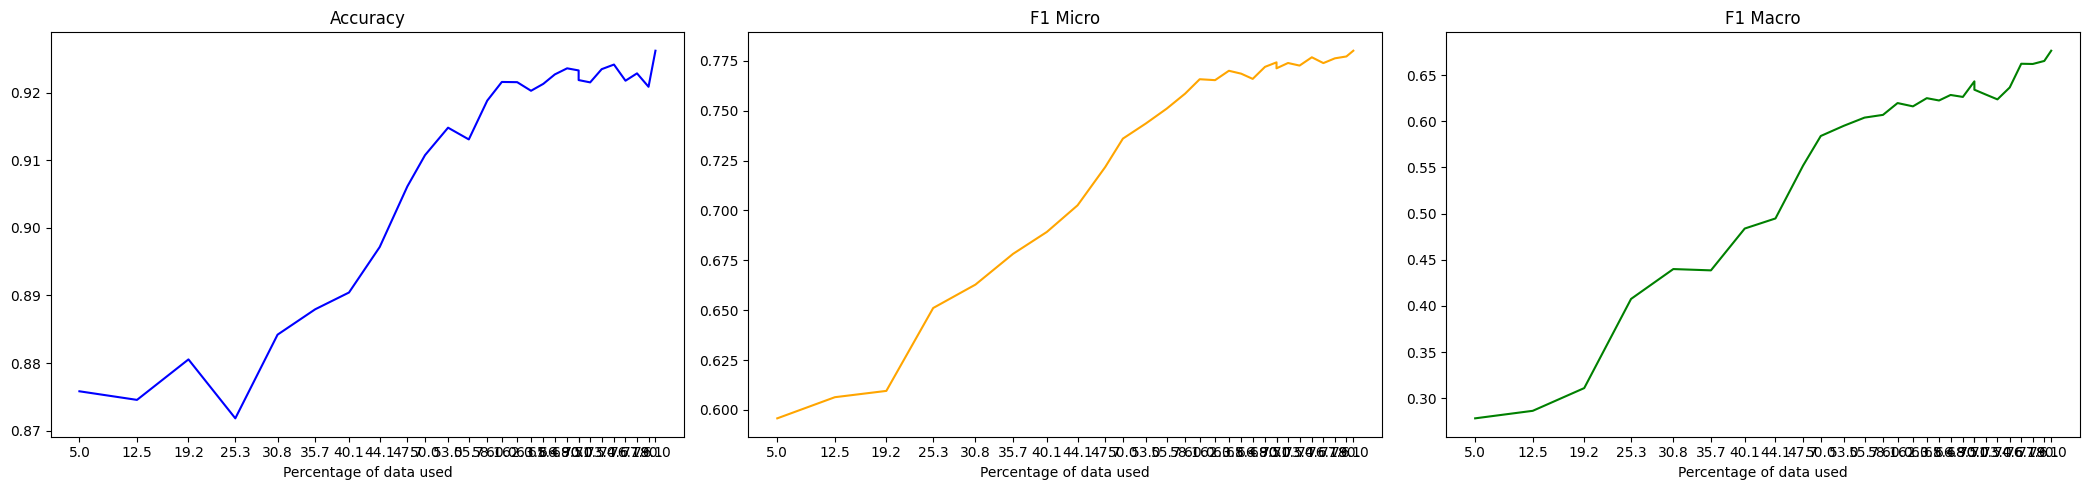

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.598, Accuracy: 0.831, F1 Micro: 0.1955, F1 Macro: 0.0519
Epoch 2/10, Train Loss: 0.4533, Accuracy: 0.8295, F1 Micro: 0.0546, F1 Macro: 0.0197
Epoch 3/10, Train Loss: 0.4229, Accuracy: 0.835, F1 Micro: 0.1221, F1 Macro: 0.0472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3844, Accuracy: 0.8464, F1 Micro: 0.2682, F1 Macro: 0.0907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3786, Accuracy: 0.848, F1 Micro: 0.2905, F1 Macro: 0.0962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.353, Accuracy: 0.8561, F1 Micro: 0.4159, F1 Macro: 0.1412
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3465, Accuracy: 0.8651, F1 Micro: 0.4363, F1 Macro: 0.1893
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3138, Accuracy: 0.8708, F1 Micro: 0.5781, F1 Macro: 0.2666
Epoch 9/10, Train Loss: 0.3048, Accuracy: 0.8742, F1 Micro: 0.5702, F1 Macro: 0.2653
Epoch 10/10, Train Loss: 0.2677, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4556, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2828, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2386, Accuracy: 0.843, F1 Micro: 0.2764, F1 Macro: 0.0911
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2033, Accuracy: 0.8567, F1 Micro: 0.5122, F1 Macro: 0.2281
Epoch 5/10, Train Loss: 0.1882, Accuracy: 0.866, F1 Micro: 0.4966, F1 Macro: 0.2291
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1621, Accuracy: 0.8704, F1 Micro: 0.5312, F1 Macro: 0.2458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1526, Accuracy: 0.8721, F1 Micro: 0.5691, F1 Macro: 0.2644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1481, Accuracy: 0.8668, F1 Micro: 0.6066, F1 Macro: 0.2887
Epoch 9/10, Train Loss: 0.1297, Accuracy: 0.8743, F1 Micro: 0.5769, F1 Macro: 0.2708
Epoch 10/10, Train

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2214, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.8431, F1 Micro: 0.2595, F1 Macro: 0.0941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.8599, F1 Micro: 0.5493, F1 Macro: 0.2507
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.8672, F1 Micro: 0.4967, F1 Macro: 0.2285
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.8666, F1 Micro: 0.5926, F1 Macro: 0.2742
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.8736, F1 Micro: 0.5856, F1 Macro: 0.2728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.8753, F1 Micro: 0.6009, F1 Macro: 0.2932
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0918, Accuracy: 0.8713, F1 Micro: 0.6155, F1 Macro: 0.3081
Higher F1 achieved, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3414, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1952, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.8433, F1 Micro: 0.2053, F1 Macro: 0.0747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.8654, F1 Micro: 0.5289, F1 Macro: 0.245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.8705, F1 Micro: 0.5569, F1 Macro: 0.257
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.8758, F1 Micro: 0.5822, F1 Macro: 0.2732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.868, F1 Micro: 0.6213, F1 Macro: 0.2952
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.8747, F1 Micro: 0.6109, F1 Macro: 0.305
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.8722, F1 Micro: 0.6291, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.324, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2108, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.8433, F1 Micro: 0.1859, F1 Macro: 0.0699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.8699, F1 Micro: 0.565, F1 Macro: 0.2609
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.8726, F1 Micro: 0.605, F1 Macro: 0.3236
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.8745, F1 Micro: 0.6237, F1 Macro: 0.3214
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.8794, F1 Micro: 0.6358, F1 Macro: 0.3408
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.8761, F1 Micro: 0.6444, F1 Macro: 0.3803
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.8854, F1 Micro: 0.6358, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3149, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.201, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.8551, F1 Micro: 0.3131, F1 Macro: 0.1195
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.875, F1 Micro: 0.5321, F1 Macro: 0.2507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.8792, F1 Micro: 0.6211, F1 Macro: 0.3236
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.8825, F1 Micro: 0.6402, F1 Macro: 0.3121
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.8817, F1 Micro: 0.6563, F1 Macro: 0.3778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.8831, F1 Micro: 0.6691, F1 Macro: 0.4303
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.8893, F1 Micro: 0.6521, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3129, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2058, Accuracy: 0.8278, F1 Micro: 0.0004, F1 Macro: 0.0002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.8648, F1 Micro: 0.4205, F1 Macro: 0.199
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.8786, F1 Micro: 0.5469, F1 Macro: 0.2596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.8822, F1 Micro: 0.6592, F1 Macro: 0.3511
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.8898, F1 Micro: 0.6747, F1 Macro: 0.4168
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.892, F1 Micro: 0.683, F1 Macro: 0.4457
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.8941, F1 Micro: 0.6797, F1 Macro: 0.4558
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.8958, F1 Micro: 0.6819, F1 Macro: 0.4745
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.313, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2262, Accuracy: 0.8475, F1 Micro: 0.2361, F1 Macro: 0.0831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.8854, F1 Micro: 0.6063, F1 Macro: 0.3003
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.8877, F1 Micro: 0.6202, F1 Macro: 0.3726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.8962, F1 Micro: 0.6733, F1 Macro: 0.417
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.8978, F1 Micro: 0.6994, F1 Macro: 0.4761
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.8923, F1 Micro: 0.6976, F1 Macro: 0.4856
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9, F1 Micro: 0.6988, F1 Macro: 0.4917
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9032, F1 Micro: 0.7051, F1 Macro: 0.4786
Higher F1 achiev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3275, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.8776, F1 Micro: 0.5649, F1 Macro: 0.298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.8908, F1 Micro: 0.6294, F1 Macro: 0.3768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.8982, F1 Micro: 0.6755, F1 Macro: 0.4683
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9001, F1 Micro: 0.673, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.8977, F1 Micro: 0.7053, F1 Macro: 0.5157
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9059, F1 Micro: 0.717, F1 Macro: 0.5506
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9083, F1 Micro: 0.7235, F1 Macro: 0.5614
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9041, F1 Micro: 0.7309

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3432, Accuracy: 0.8285, F1 Micro: 0.01, F1 Macro: 0.004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.8748, F1 Micro: 0.4972, F1 Macro: 0.3285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.898, F1 Micro: 0.6944, F1 Macro: 0.5322
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9047, F1 Micro: 0.7017, F1 Macro: 0.5265
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.908, F1 Micro: 0.7312, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9081, F1 Micro: 0.7328, F1 Macro: 0.5795
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9125, F1 Micro: 0.739, F1 Macro: 0.5698
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9122, F1 Micro: 0.7365, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9105, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3486, Accuracy: 0.8404, F1 Micro: 0.1533, F1 Macro: 0.0553
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.8853, F1 Micro: 0.5663, F1 Macro: 0.3408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9031, F1 Micro: 0.6846, F1 Macro: 0.5238
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9076, F1 Micro: 0.695, F1 Macro: 0.5447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9075, F1 Micro: 0.731, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.9142, F1 Micro: 0.7407, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9107, F1 Micro: 0.7452, F1 Macro: 0.5873
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9129, F1 Micro: 0.7463, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3579, Accuracy: 0.8513, F1 Micro: 0.2792, F1 Macro: 0.1079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2447, Accuracy: 0.8955, F1 Micro: 0.6645, F1 Macro: 0.4596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9024, F1 Micro: 0.6665, F1 Macro: 0.52
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9096, F1 Micro: 0.7287, F1 Macro: 0.5512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9143, F1 Micro: 0.7343, F1 Macro: 0.5769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1098, Accuracy: 0.906, F1 Micro: 0.7424, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.9141, F1 Micro: 0.7523, F1 Macro: 0.612
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9149, F1 Micro: 0.7493, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9172, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3612, Accuracy: 0.8597, F1 Micro: 0.4087, F1 Macro: 0.1911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.8962, F1 Micro: 0.6649, F1 Macro: 0.4792
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9082, F1 Micro: 0.7104, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9116, F1 Micro: 0.732, F1 Macro: 0.5743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9153, F1 Micro: 0.7464, F1 Macro: 0.5931
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9167, F1 Micro: 0.7465, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9156, F1 Micro: 0.7506, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9168, F1 Micro: 0.7596, F1 Macro: 0.6122
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3637, Accuracy: 0.868, F1 Micro: 0.5248, F1 Macro: 0.2663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.8956, F1 Micro: 0.647, F1 Macro: 0.4716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1946, Accuracy: 0.9085, F1 Micro: 0.71, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9116, F1 Micro: 0.7432, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9139, F1 Micro: 0.7509, F1 Macro: 0.593
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9167, F1 Micro: 0.7473, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9192, F1 Micro: 0.7562, F1 Macro: 0.6098
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9182, F1 Micro: 0.7441, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9172, F1 Micro: 0.7614, F1 Macro: 0.6181
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.367, Accuracy: 0.8715, F1 Micro: 0.4742, F1 Macro: 0.2135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9, F1 Micro: 0.6893, F1 Macro: 0.5012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.909, F1 Micro: 0.7154, F1 Macro: 0.5359
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9132, F1 Micro: 0.7498, F1 Macro: 0.6012
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.917, F1 Micro: 0.7423, F1 Macro: 0.5736
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9193, F1 Micro: 0.7419, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9174, F1 Micro: 0.763, F1 Macro: 0.6133
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9189, F1 Micro: 0.7624, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9206, F1 Micro: 0.7659, F1 Macro: 0.617
Epoch 10/10, Train Loss: 0.0596, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3663, Accuracy: 0.8779, F1 Micro: 0.5479, F1 Macro: 0.2815
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.9029, F1 Micro: 0.7004, F1 Macro: 0.5212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9131, F1 Micro: 0.7373, F1 Macro: 0.5695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9163, F1 Micro: 0.7432, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9186, F1 Micro: 0.7597, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9213, F1 Micro: 0.7643, F1 Macro: 0.615
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9147, F1 Micro: 0.7593, F1 Macro: 0.6018
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9215, F1 Micro: 0.7598, F1 Macro: 0.6159
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9169, F1 Micro: 0.7584, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3632, Accuracy: 0.8796, F1 Micro: 0.5788, F1 Macro: 0.2934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.9001, F1 Micro: 0.7031, F1 Macro: 0.4874
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9135, F1 Micro: 0.7216, F1 Macro: 0.5467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9187, F1 Micro: 0.758, F1 Macro: 0.6074
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9202, F1 Micro: 0.7579, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9226, F1 Micro: 0.7638, F1 Macro: 0.6148
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9197, F1 Micro: 0.7584, F1 Macro: 0.6092
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9207, F1 Micro: 0.7602, F1 Macro: 0.6187
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9168, F1 Micro: 0.7583, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0629, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3622, Accuracy: 0.8812, F1 Micro: 0.5634, F1 Macro: 0.2892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.9034, F1 Micro: 0.6942, F1 Macro: 0.4808
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9139, F1 Micro: 0.7198, F1 Macro: 0.5407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9173, F1 Micro: 0.7479, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9212, F1 Micro: 0.7564, F1 Macro: 0.591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9192, F1 Micro: 0.769, F1 Macro: 0.6195
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9181, F1 Micro: 0.7682, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9207, F1 Micro: 0.7721, F1 Macro: 0.6269
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9248, F1 Micro: 0.7668, F1 Macro: 0.6312
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3653, Accuracy: 0.8839, F1 Micro: 0.6137, F1 Macro: 0.3287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.9053, F1 Micro: 0.7068, F1 Macro: 0.4886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9134, F1 Micro: 0.716, F1 Macro: 0.5534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9177, F1 Micro: 0.7388, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9169, F1 Micro: 0.7672, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9234, F1 Micro: 0.7698, F1 Macro: 0.6165
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.921, F1 Micro: 0.7618, F1 Macro: 0.6041
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9171, F1 Micro: 0.7607, F1 Macro: 0.6258
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9228, F1 Micro: 0.7611, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8846, F1 Micro: 0.6066, F1 Macro: 0.3216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2397, Accuracy: 0.9034, F1 Micro: 0.6745, F1 Macro: 0.4705
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9145, F1 Micro: 0.7426, F1 Macro: 0.5715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.92, F1 Micro: 0.7606, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9207, F1 Micro: 0.7686, F1 Macro: 0.6257
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9239, F1 Micro: 0.768, F1 Macro: 0.6257
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9212, F1 Micro: 0.7672, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9221, F1 Micro: 0.7713, F1 Macro: 0.6273
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9229, F1 Micro: 0.7702, F1 Macro: 0.6367
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3642, Accuracy: 0.884, F1 Micro: 0.6007, F1 Macro: 0.3026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2418, Accuracy: 0.902, F1 Micro: 0.6985, F1 Macro: 0.4848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9164, F1 Micro: 0.7363, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9199, F1 Micro: 0.7577, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9218, F1 Micro: 0.7585, F1 Macro: 0.594
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9217, F1 Micro: 0.7686, F1 Macro: 0.6114
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9208, F1 Micro: 0.7596, F1 Macro: 0.6127
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.92, F1 Micro: 0.7662, F1 Macro: 0.6199
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.92, F1 Micro: 0.7668, F1 Macro: 0.6201
Epoch 10/10, Train Loss: 0.0607, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3645, Accuracy: 0.886, F1 Micro: 0.6088, F1 Macro: 0.3164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9033, F1 Micro: 0.6699, F1 Macro: 0.5005
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9157, F1 Micro: 0.7339, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9182, F1 Micro: 0.7452, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.919, F1 Micro: 0.7636, F1 Macro: 0.6232
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.924, F1 Micro: 0.7605, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9224, F1 Micro: 0.7693, F1 Macro: 0.6231
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9203, F1 Micro: 0.7696, F1 Macro: 0.6195
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.9209, F1 Micro: 0.7658, F1 Macro: 0.633
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3678, Accuracy: 0.8863, F1 Micro: 0.6134, F1 Macro: 0.3208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.9046, F1 Micro: 0.7035, F1 Macro: 0.4597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.918, F1 Micro: 0.7469, F1 Macro: 0.5692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.914, F1 Micro: 0.757, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.922, F1 Micro: 0.7671, F1 Macro: 0.6238
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9219, F1 Micro: 0.7628, F1 Macro: 0.614
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9219, F1 Micro: 0.7629, F1 Macro: 0.6241
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9186, F1 Micro: 0.7699, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9206, F1 Micro: 0.7724, F1 Macro: 0.6501
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3641, Accuracy: 0.8882, F1 Micro: 0.636, F1 Macro: 0.3618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.9079, F1 Micro: 0.7227, F1 Macro: 0.5383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9158, F1 Micro: 0.7486, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.922, F1 Micro: 0.7631, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9229, F1 Micro: 0.7717, F1 Macro: 0.625
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.9236, F1 Micro: 0.7613, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.9237, F1 Micro: 0.7765, F1 Macro: 0.6499
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.92, F1 Micro: 0.7694, F1 Macro: 0.6326
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9208, F1 Micro: 0.7721, F1 Macro: 0.6529
Epoch 10/10, Train Loss: 0.0609, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3661, Accuracy: 0.8879, F1 Micro: 0.6416, F1 Macro: 0.3584
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.9077, F1 Micro: 0.7127, F1 Macro: 0.5344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9148, F1 Micro: 0.7498, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9162, F1 Micro: 0.7584, F1 Macro: 0.6108
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9217, F1 Micro: 0.7721, F1 Macro: 0.6272
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9238, F1 Micro: 0.7712, F1 Macro: 0.6374
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9243, F1 Micro: 0.7694, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9245, F1 Micro: 0.7721, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9243, F1 Micro: 0.7736, F1 Macro: 0.6748
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3657, Accuracy: 0.889, F1 Micro: 0.6244, F1 Macro: 0.3265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2449, Accuracy: 0.9068, F1 Micro: 0.6816, F1 Macro: 0.4918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9149, F1 Micro: 0.7523, F1 Macro: 0.5855
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.92, F1 Micro: 0.7513, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9223, F1 Micro: 0.7583, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.9241, F1 Micro: 0.7716, F1 Macro: 0.6373
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9185, F1 Micro: 0.7698, F1 Macro: 0.6511
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.924, F1 Micro: 0.7782, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9253, F1 Micro: 0.7771, F1 Macro: 0.6736
Epoch 10/10, Train Loss: 0.0655, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.8892, F1 Micro: 0.6424, F1 Macro: 0.3379
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2396, Accuracy: 0.9085, F1 Micro: 0.7069, F1 Macro: 0.5255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.914, F1 Micro: 0.7095, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9222, F1 Micro: 0.7644, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9244, F1 Micro: 0.7751, F1 Macro: 0.6414
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9244, F1 Micro: 0.7754, F1 Macro: 0.6531
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9223, F1 Micro: 0.7734, F1 Macro: 0.6656
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9196, F1 Micro: 0.773, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9252, F1 Micro: 0.7768, F1 Macro: 0.6968
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3641, Accuracy: 0.8907, F1 Micro: 0.6406, F1 Macro: 0.332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.9074, F1 Micro: 0.6934, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9186, F1 Micro: 0.7472, F1 Macro: 0.5683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9218, F1 Micro: 0.765, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9232, F1 Micro: 0.7748, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9242, F1 Micro: 0.7807, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.928, F1 Micro: 0.7813, F1 Macro: 0.6821
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9256, F1 Micro: 0.7796, F1 Macro: 0.6896
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9236, F1 Micro: 0.7722, F1 Macro: 0.6912
Epoch 10/

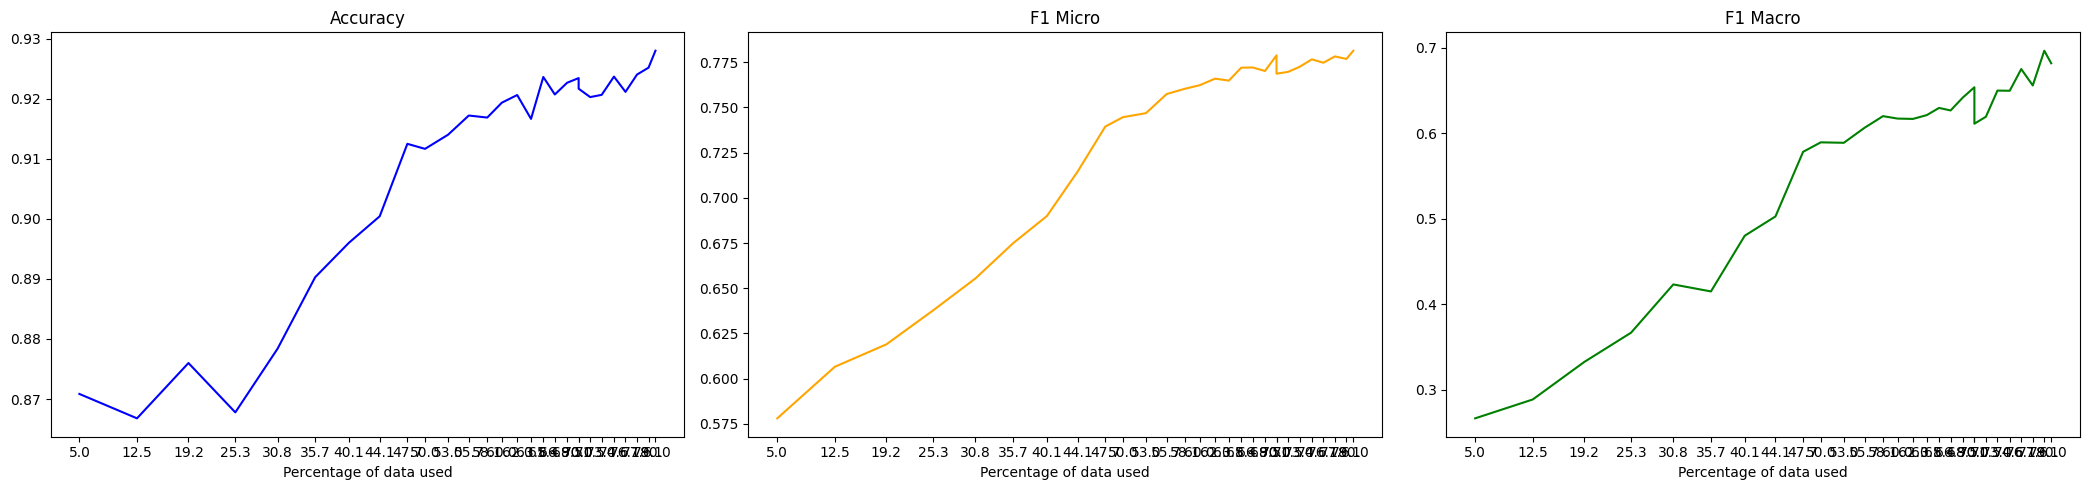

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6126, Accuracy: 0.8292, F1 Micro: 0.1246, F1 Macro: 0.0417
Epoch 2/10, Train Loss: 0.466, Accuracy: 0.8283, F1 Micro: 0.0135, F1 Macro: 0.006
Epoch 3/10, Train Loss: 0.4052, Accuracy: 0.8326, F1 Micro: 0.0744, F1 Macro: 0.0285
Epoch 4/10, Train Loss: 0.3854, Accuracy: 0.8366, F1 Micro: 0.1202, F1 Macro: 0.0461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3789, Accuracy: 0.846, F1 Micro: 0.2352, F1 Macro: 0.0831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.367, Accuracy: 0.8566, F1 Micro: 0.3727, F1 Macro: 0.1226
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3376, Accuracy: 0.8669, F1 Micro: 0.4634, F1 Macro: 0.2008
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3093, Accuracy: 0.8723, F1 Micro: 0.5046, F1 Macro: 0.2333
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2958, Accuracy: 0.875, F1 Micro: 0.5295, F1 Macro: 0.2488
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.485, Accuracy: 0.8278, F1 Micro: 0.0004, F1 Macro: 0.0002
Epoch 2/10, Train Loss: 0.2832, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2547, Accuracy: 0.8288, F1 Micro: 0.0125, F1 Macro: 0.0057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2284, Accuracy: 0.8474, F1 Micro: 0.3177, F1 Macro: 0.104
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2019, Accuracy: 0.8622, F1 Micro: 0.5146, F1 Macro: 0.2353
Epoch 6/10, Train Loss: 0.1788, Accuracy: 0.8633, F1 Micro: 0.4596, F1 Macro: 0.2156
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1587, Accuracy: 0.8691, F1 Micro: 0.585, F1 Macro: 0.2705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1509, Accuracy: 0.8646, F1 Micro: 0.6083, F1 Macro: 0.3068
Epoch 9/10, Train Loss: 0.1365, Accuracy: 0.8736, F1 Micro: 0.5904, F1 Macro: 0.2916
Epoch 10/10, Train Loss: 0.1237, Accuracy: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3952, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.8393, F1 Micro: 0.1703, F1 Macro: 0.0567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.8606, F1 Micro: 0.443, F1 Macro: 0.1977
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.8639, F1 Micro: 0.4956, F1 Macro: 0.2295
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.8643, F1 Micro: 0.5868, F1 Macro: 0.2727
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.8734, F1 Micro: 0.5516, F1 Macro: 0.2525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.8709, F1 Micro: 0.6102, F1 Macro: 0.3184
Epoch 9/10, Train Loss: 0.0918, Accuracy: 0.8751, F1 Micro: 0.5669, F1 Macro: 0.296
Higher F1 achieved

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3567, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2082, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.8393, F1 Micro: 0.1513, F1 Macro: 0.0561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.862, F1 Micro: 0.4563, F1 Macro: 0.215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.8678, F1 Micro: 0.4821, F1 Macro: 0.2248
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.8674, F1 Micro: 0.6215, F1 Macro: 0.3229
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.8733, F1 Micro: 0.5429, F1 Macro: 0.283
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.8674, F1 Micro: 0.6283, F1 Macro: 0.3438
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.8803, F1 Micro: 0.6348, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3368, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2018, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.8388, F1 Micro: 0.152, F1 Macro: 0.057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.8639, F1 Micro: 0.4612, F1 Macro: 0.2185
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.8759, F1 Micro: 0.5878, F1 Macro: 0.274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.877, F1 Micro: 0.612, F1 Macro: 0.2913
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.8769, F1 Micro: 0.6266, F1 Macro: 0.3432
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.8771, F1 Micro: 0.644, F1 Macro: 0.367
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.328, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2075, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.8517, F1 Micro: 0.2789, F1 Macro: 0.1111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.877, F1 Micro: 0.5839, F1 Macro: 0.2757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.8814, F1 Micro: 0.5977, F1 Macro: 0.2956
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.883, F1 Micro: 0.6491, F1 Macro: 0.342
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.8855, F1 Micro: 0.6476, F1 Macro: 0.3758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.8863, F1 Micro: 0.6588, F1 Macro: 0.4046
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.8809, F1 Micro: 0.6699, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.327, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2102, Accuracy: 0.831, F1 Micro: 0.0408, F1 Macro: 0.0173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.8748, F1 Micro: 0.5392, F1 Macro: 0.2472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.8834, F1 Micro: 0.591, F1 Macro: 0.279
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.8857, F1 Micro: 0.6529, F1 Macro: 0.3433
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.8903, F1 Micro: 0.6443, F1 Macro: 0.3497
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.8904, F1 Micro: 0.6774, F1 Macro: 0.4051
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.8873, F1 Micro: 0.6772, F1 Macro: 0.4502
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.8938, F1 Micro: 0.6818, F1 Macro: 0.463
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3216, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.8372, F1 Micro: 0.1161, F1 Macro: 0.0418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.8747, F1 Micro: 0.5358, F1 Macro: 0.2698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.8823, F1 Micro: 0.557, F1 Macro: 0.2856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.8914, F1 Micro: 0.6354, F1 Macro: 0.3713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.8908, F1 Micro: 0.6973, F1 Macro: 0.4719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.8956, F1 Micro: 0.6981, F1 Macro: 0.4744
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9005, F1 Micro: 0.6979, F1 Macro: 0.4779
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.8991, F1 Micro: 0.70

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3426, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2496, Accuracy: 0.8597, F1 Micro: 0.3441, F1 Macro: 0.1444
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.8934, F1 Micro: 0.6453, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.8968, F1 Micro: 0.6534, F1 Macro: 0.4455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.8991, F1 Micro: 0.6606, F1 Macro: 0.4542
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9021, F1 Micro: 0.7064, F1 Macro: 0.5057
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9028, F1 Micro: 0.7, F1 Macro: 0.5152
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9027, F1 Micro: 0.7036, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9066, F1 Micro: 0.7188, F1 Macro: 0.5336
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3539, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2379, Accuracy: 0.8721, F1 Micro: 0.4738, F1 Macro: 0.2702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.8946, F1 Micro: 0.632, F1 Macro: 0.4737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9041, F1 Micro: 0.687, F1 Macro: 0.4983
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9076, F1 Micro: 0.7167, F1 Macro: 0.5483
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.905, F1 Micro: 0.7236, F1 Macro: 0.5618
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9086, F1 Micro: 0.7203, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9126, F1 Micro: 0.7353, F1 Macro: 0.5775
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9113, F1 Micro: 0.742

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3574, Accuracy: 0.8311, F1 Micro: 0.0425, F1 Macro: 0.0181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.8895, F1 Micro: 0.6458, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9011, F1 Micro: 0.7021, F1 Macro: 0.5263
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9049, F1 Micro: 0.7098, F1 Macro: 0.5639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9083, F1 Micro: 0.7199, F1 Macro: 0.563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9056, F1 Micro: 0.7367, F1 Macro: 0.5702
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9122, F1 Micro: 0.7341, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9112, F1 Micro: 0.7454, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9115, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3703, Accuracy: 0.8442, F1 Micro: 0.2033, F1 Macro: 0.0782
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.8929, F1 Micro: 0.6427, F1 Macro: 0.4639
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.9038, F1 Micro: 0.6951, F1 Macro: 0.4728
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9025, F1 Micro: 0.6628, F1 Macro: 0.5141
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9144, F1 Micro: 0.7303, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9157, F1 Micro: 0.7503, F1 Macro: 0.6034
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9138, F1 Micro: 0.7454, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9162, F1 Micro: 0.7567, F1 Macro: 0.6165
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.918, F1 Micro: 0.7499, F1 Macro: 0.594
Epoch 10/10, Train Loss: 0.0602, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3615, Accuracy: 0.8552, F1 Micro: 0.3216, F1 Macro: 0.1315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.8904, F1 Micro: 0.608, F1 Macro: 0.416
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.8943, F1 Micro: 0.6034, F1 Macro: 0.4397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9104, F1 Micro: 0.7213, F1 Macro: 0.5508
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.911, F1 Micro: 0.7436, F1 Macro: 0.5873
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9149, F1 Micro: 0.7446, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9138, F1 Micro: 0.7518, F1 Macro: 0.6093
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9156, F1 Micro: 0.7441, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9171, F1 Micro: 0.7537, F1 Macro: 0.6025
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8606, F1 Micro: 0.3724, F1 Macro: 0.1599
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.8967, F1 Micro: 0.6649, F1 Macro: 0.4488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9069, F1 Micro: 0.7234, F1 Macro: 0.549
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9121, F1 Micro: 0.7178, F1 Macro: 0.5616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.916, F1 Micro: 0.728, F1 Macro: 0.5544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9142, F1 Micro: 0.7558, F1 Macro: 0.6079
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9184, F1 Micro: 0.7534, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9153, F1 Micro: 0.7572, F1 Macro: 0.6036
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9195, F1 Micro: 0.7509, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8732, F1 Micro: 0.4891, F1 Macro: 0.2221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9, F1 Micro: 0.6741, F1 Macro: 0.4535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9066, F1 Micro: 0.7275, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9138, F1 Micro: 0.7443, F1 Macro: 0.5652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9157, F1 Micro: 0.7546, F1 Macro: 0.5848
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9193, F1 Micro: 0.7519, F1 Macro: 0.607
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9202, F1 Micro: 0.7671, F1 Macro: 0.6188
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9198, F1 Micro: 0.7564, F1 Macro: 0.598
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9184, F1 Micro: 0.7664, F1 Macro: 0.6199
Epoch 10/10, Train Loss: 0.058, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3735, Accuracy: 0.8805, F1 Micro: 0.5708, F1 Macro: 0.2652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2442, Accuracy: 0.9, F1 Micro: 0.6865, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9086, F1 Micro: 0.7185, F1 Macro: 0.5403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.915, F1 Micro: 0.7379, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9178, F1 Micro: 0.7584, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9178, F1 Micro: 0.7653, F1 Macro: 0.6141
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9211, F1 Micro: 0.7594, F1 Macro: 0.614
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9196, F1 Micro: 0.7535, F1 Macro: 0.5951
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9156, F1 Micro: 0.7587, F1 Macro: 0.6238
Epoch 10/10, Train Loss: 0.0597, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3703, Accuracy: 0.8812, F1 Micro: 0.5761, F1 Macro: 0.2701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.8961, F1 Micro: 0.7018, F1 Macro: 0.4999
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9083, F1 Micro: 0.7226, F1 Macro: 0.5682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9178, F1 Micro: 0.7456, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9196, F1 Micro: 0.7549, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9212, F1 Micro: 0.7588, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9204, F1 Micro: 0.7593, F1 Macro: 0.6166
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9178, F1 Micro: 0.754, F1 Macro: 0.6057
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9205, F1 Micro: 0.7544, F1 Macro: 0.6157
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.8782, F1 Micro: 0.5264, F1 Macro: 0.2462
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.902, F1 Micro: 0.6745, F1 Macro: 0.444
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9114, F1 Micro: 0.7301, F1 Macro: 0.5639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9182, F1 Micro: 0.7562, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9153, F1 Micro: 0.7629, F1 Macro: 0.6109
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9166, F1 Micro: 0.7626, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.923, F1 Micro: 0.7658, F1 Macro: 0.6216
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9194, F1 Micro: 0.7639, F1 Macro: 0.6143
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9211, F1 Micro: 0.7575, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.8796, F1 Micro: 0.5421, F1 Macro: 0.2551
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9024, F1 Micro: 0.6734, F1 Macro: 0.443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9137, F1 Micro: 0.7355, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9176, F1 Micro: 0.7464, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9189, F1 Micro: 0.7505, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9188, F1 Micro: 0.7649, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9206, F1 Micro: 0.7656, F1 Macro: 0.6155
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9172, F1 Micro: 0.7577, F1 Macro: 0.6265
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9233, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3764, Accuracy: 0.8804, F1 Micro: 0.5479, F1 Macro: 0.2603
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.9023, F1 Micro: 0.705, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9115, F1 Micro: 0.7369, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9165, F1 Micro: 0.7566, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9113, F1 Micro: 0.7592, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9222, F1 Micro: 0.7749, F1 Macro: 0.6277
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9216, F1 Micro: 0.772, F1 Macro: 0.6361
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.92, F1 Micro: 0.7692, F1 Macro: 0.6369
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9231, F1 Micro: 0.7731, F1 Macro: 0.6513
Epoch 10/10, Train Loss: 0.0617, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.8827, F1 Micro: 0.5576, F1 Macro: 0.2601
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.9033, F1 Micro: 0.6869, F1 Macro: 0.4785
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1946, Accuracy: 0.9137, F1 Micro: 0.7449, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9201, F1 Micro: 0.7552, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.921, F1 Micro: 0.7614, F1 Macro: 0.6014
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9221, F1 Micro: 0.7749, F1 Macro: 0.6284
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.922, F1 Micro: 0.7721, F1 Macro: 0.6317
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9241, F1 Micro: 0.7647, F1 Macro: 0.633
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.924, F1 Micro: 0.7729, F1 Macro: 0.6448
Epoch 10/10, Train Loss: 0.0613, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.371, Accuracy: 0.8854, F1 Micro: 0.5974, F1 Macro: 0.2914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9052, F1 Micro: 0.6985, F1 Macro: 0.4766
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9148, F1 Micro: 0.7503, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9147, F1 Micro: 0.7644, F1 Macro: 0.6136
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9231, F1 Micro: 0.7599, F1 Macro: 0.6091
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9222, F1 Micro: 0.7522, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9213, F1 Micro: 0.7686, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9244, F1 Micro: 0.7772, F1 Macro: 0.6584
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9227, F1 Micro: 0.7778, F1 Macro: 0.6569
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.881, F1 Micro: 0.6436, F1 Macro: 0.3276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9058, F1 Micro: 0.691, F1 Macro: 0.4897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.912, F1 Micro: 0.7456, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9215, F1 Micro: 0.765, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9244, F1 Micro: 0.7654, F1 Macro: 0.6202
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9208, F1 Micro: 0.7704, F1 Macro: 0.6316
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9232, F1 Micro: 0.7726, F1 Macro: 0.632
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9219, F1 Micro: 0.7612, F1 Macro: 0.6381
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9234, F1 Micro: 0.7706, F1 Macro: 0.6555
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3721, Accuracy: 0.8851, F1 Micro: 0.5849, F1 Macro: 0.2879
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.246, Accuracy: 0.9065, F1 Micro: 0.7012, F1 Macro: 0.4854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.915, F1 Micro: 0.7421, F1 Macro: 0.5698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.918, F1 Micro: 0.7642, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9228, F1 Micro: 0.767, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9224, F1 Micro: 0.7745, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9218, F1 Micro: 0.7761, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9216, F1 Micro: 0.771, F1 Macro: 0.6499
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9246, F1 Micro: 0.7739, F1 Macro: 0.647
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3734, Accuracy: 0.888, F1 Micro: 0.6387, F1 Macro: 0.3197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.9063, F1 Micro: 0.713, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9173, F1 Micro: 0.7426, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9186, F1 Micro: 0.7643, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9153, F1 Micro: 0.7654, F1 Macro: 0.6314
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9244, F1 Micro: 0.7744, F1 Macro: 0.6394
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9233, F1 Micro: 0.7676, F1 Macro: 0.6566
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9212, F1 Micro: 0.7694, F1 Macro: 0.6605
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9202, F1 Micro: 0.7652, F1 Macro: 0.6801
Epoch 10/10, Train Loss: 0.0634, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.8881, F1 Micro: 0.6457, F1 Macro: 0.342
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.9051, F1 Micro: 0.7131, F1 Macro: 0.4882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9167, F1 Micro: 0.7459, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9127, F1 Micro: 0.7605, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9169, F1 Micro: 0.7675, F1 Macro: 0.6214
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.924, F1 Micro: 0.7705, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9218, F1 Micro: 0.7753, F1 Macro: 0.6498
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9237, F1 Micro: 0.7711, F1 Macro: 0.6626
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9227, F1 Micro: 0.7742, F1 Macro: 0.6803
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3723, Accuracy: 0.8885, F1 Micro: 0.6536, F1 Macro: 0.3412
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9057, F1 Micro: 0.7213, F1 Macro: 0.5311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9109, F1 Micro: 0.7482, F1 Macro: 0.5793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9201, F1 Micro: 0.7716, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9222, F1 Micro: 0.7765, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9231, F1 Micro: 0.7732, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9249, F1 Micro: 0.7794, F1 Macro: 0.6855
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9244, F1 Micro: 0.7791, F1 Macro: 0.6903
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9237, F1 Micro: 0.775, F1 Macro: 0.6995
Epoch 10/10, Train Loss: 0.0604, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.8815, F1 Micro: 0.6612, F1 Macro: 0.3631
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.9071, F1 Micro: 0.702, F1 Macro: 0.4691
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9147, F1 Micro: 0.7494, F1 Macro: 0.5607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9202, F1 Micro: 0.7638, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9244, F1 Micro: 0.771, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9255, F1 Micro: 0.7799, F1 Macro: 0.6938
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9239, F1 Micro: 0.7798, F1 Macro: 0.7003
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9184, F1 Micro: 0.7749, F1 Macro: 0.6978
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9231, F1 Micro: 0.7738, F1 Macro: 0.7106
Epoch 10/10, Train Loss: 0.0639, Accurac

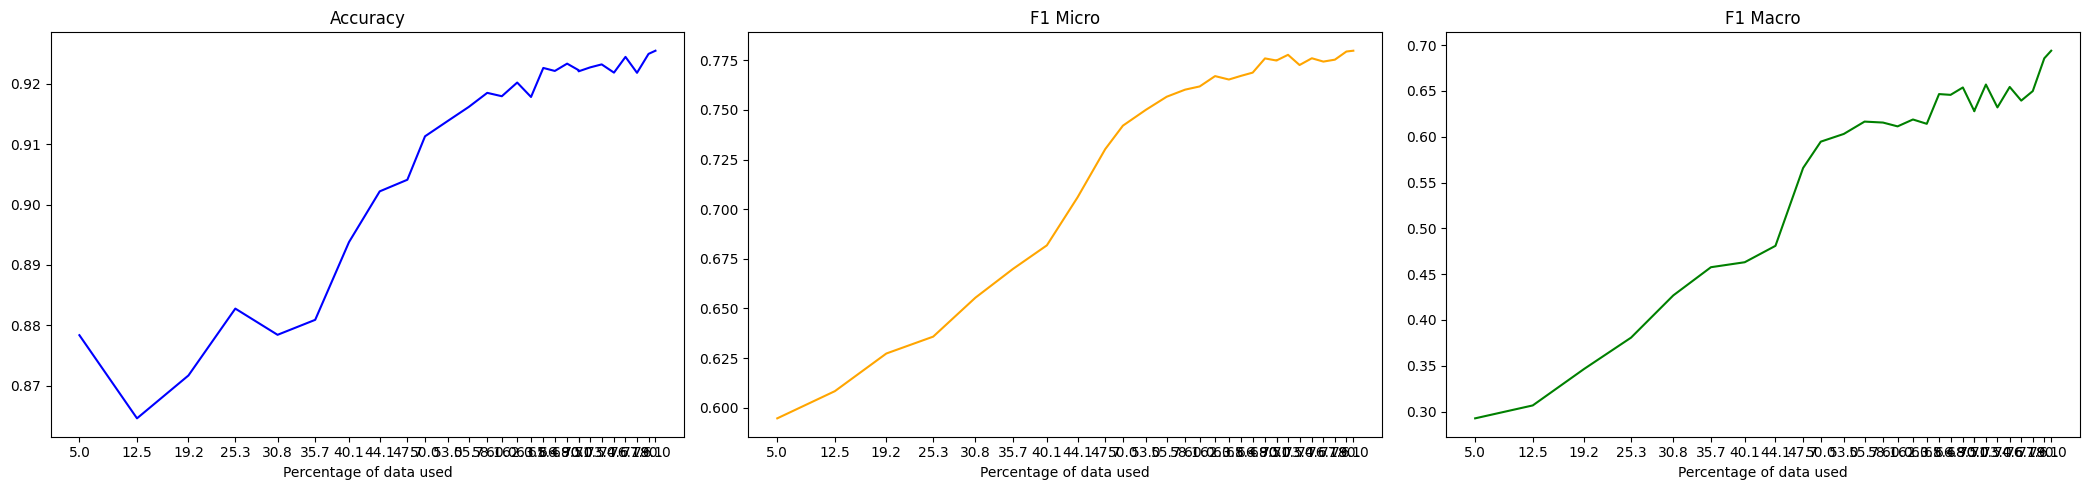

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6229, Accuracy: 0.8175, F1 Micro: 0.1735, F1 Macro: 0.084
Epoch 2/10, Train Loss: 0.4626, Accuracy: 0.8323, F1 Micro: 0.088, F1 Macro: 0.0328
Epoch 3/10, Train Loss: 0.4094, Accuracy: 0.8314, F1 Micro: 0.0611, F1 Macro: 0.0245
Epoch 4/10, Train Loss: 0.4066, Accuracy: 0.8369, F1 Micro: 0.1189, F1 Macro: 0.0463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3749, Accuracy: 0.8493, F1 Micro: 0.2718, F1 Macro: 0.0926
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3771, Accuracy: 0.858, F1 Micro: 0.3885, F1 Macro: 0.1306
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3505, Accuracy: 0.8657, F1 Micro: 0.4924, F1 Macro: 0.2095
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3263, Accuracy: 0.8741, F1 Micro: 0.5344, F1 Macro: 0.2477
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2903, Accuracy: 0.8768, F1 Micro: 0.5831, F1 Macro: 0.2794
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4861, Accuracy: 0.8277, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2461, Accuracy: 0.8302, F1 Micro: 0.0301, F1 Macro: 0.0131
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2217, Accuracy: 0.8515, F1 Micro: 0.3823, F1 Macro: 0.1514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1894, Accuracy: 0.8625, F1 Micro: 0.5042, F1 Macro: 0.2281
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.17, Accuracy: 0.8652, F1 Micro: 0.5314, F1 Macro: 0.2467
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1573, Accuracy: 0.8699, F1 Micro: 0.5757, F1 Macro: 0.2703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1456, Accuracy: 0.8715, F1 Micro: 0.6005, F1 Macro: 0.3014
Epoch 9/10, Train Loss: 0.1267, Accuracy: 0.877, F1 Micro: 0.5541, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4037, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2205, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.8406, F1 Micro: 0.2085, F1 Macro: 0.0814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.8596, F1 Micro: 0.5086, F1 Macro: 0.2271
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.8645, F1 Micro: 0.5266, F1 Macro: 0.2444
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.862, F1 Micro: 0.5788, F1 Macro: 0.2727
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.8715, F1 Micro: 0.5248, F1 Macro: 0.2436
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1026, Accuracy: 0.8743, F1 Micro: 0.595, F1 Macro: 0.3198
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0887, Accuracy: 0.8739, F1 Micro: 0.6163, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3585, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2013, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.8441, F1 Micro: 0.2273, F1 Macro: 0.0835
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.8629, F1 Micro: 0.5411, F1 Macro: 0.251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.8681, F1 Micro: 0.5919, F1 Macro: 0.2808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.8727, F1 Micro: 0.614, F1 Macro: 0.3159
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.8744, F1 Micro: 0.6298, F1 Macro: 0.3458
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.8792, F1 Micro: 0.6135, F1 Macro: 0.3265
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.8803, F1 Micro: 0.6202, F1 Macro: 0.3693
Higher F1 achieved,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.34, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2103, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.846, F1 Micro: 0.2523, F1 Macro: 0.0904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.8651, F1 Micro: 0.5112, F1 Macro: 0.2419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.8718, F1 Micro: 0.6196, F1 Macro: 0.3233
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.8795, F1 Micro: 0.6099, F1 Macro: 0.3248
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.8776, F1 Micro: 0.6494, F1 Macro: 0.3983
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.8801, F1 Micro: 0.6543, F1 Macro: 0.4155
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.8773, F1 Micro: 0.6607, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3298, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1997, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.8454, F1 Micro: 0.2067, F1 Macro: 0.0786
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.8739, F1 Micro: 0.6068, F1 Macro: 0.3077
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.8776, F1 Micro: 0.629, F1 Macro: 0.3631
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.8779, F1 Micro: 0.6495, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.8797, F1 Micro: 0.6521, F1 Macro: 0.3734
Epoch 8/10, Train Loss: 0.074, Accuracy: 0.886, F1 Micro: 0.6508, F1 Macro: 0.4223
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.8851, F1 Micro: 0.6665, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3216, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.8689, F1 Micro: 0.4671, F1 Macro: 0.2045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.8806, F1 Micro: 0.5756, F1 Macro: 0.2846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.8838, F1 Micro: 0.6594, F1 Macro: 0.3653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.8886, F1 Micro: 0.6672, F1 Macro: 0.436
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.8898, F1 Micro: 0.6809, F1 Macro: 0.4523
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.8918, F1 Micro: 0.6612, F1 Macro: 0.4549
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.8942, F1 Micro: 0.6787, F1 Macro: 0.4441
Higher F1 achieved

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.331, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2351, Accuracy: 0.8417, F1 Micro: 0.1611, F1 Macro: 0.06
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.8853, F1 Micro: 0.6226, F1 Macro: 0.3368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.8912, F1 Micro: 0.67, F1 Macro: 0.3952
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.8884, F1 Micro: 0.6893, F1 Macro: 0.4636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.8911, F1 Micro: 0.6926, F1 Macro: 0.4781
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.8949, F1 Micro: 0.6975, F1 Macro: 0.4756
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.8867, F1 Micro: 0.6944, F1 Macro: 0.4716
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.8974, F1 Micro: 0.6836, F1 Macro: 0.4835
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3369, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.8663, F1 Micro: 0.4178, F1 Macro: 0.1879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.8914, F1 Micro: 0.6748, F1 Macro: 0.4407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.8976, F1 Micro: 0.6849, F1 Macro: 0.4592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9001, F1 Micro: 0.696, F1 Macro: 0.4641
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.8904, F1 Micro: 0.6945, F1 Macro: 0.452
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0883, Accuracy: 0.9004, F1 Micro: 0.7127, F1 Macro: 0.5196
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9041, F1 Micro: 0.7054, F1 Macro: 0.5335
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9066, F1 Micro: 0.723, F1 Macro: 0.552
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3463, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.8782, F1 Micro: 0.546, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.8936, F1 Micro: 0.6954, F1 Macro: 0.499
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9031, F1 Micro: 0.6969, F1 Macro: 0.5253
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9029, F1 Micro: 0.725, F1 Macro: 0.5488
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.905, F1 Micro: 0.715, F1 Macro: 0.5425
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9032, F1 Micro: 0.7237, F1 Macro: 0.5569
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.908, F1 Micro: 0.7154, F1 Macro: 0.5632
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9111, F1 Micro: 0.7321, F1 Macro: 0.5692
Epoch 10/10, Train Loss: 0.0593, Accuracy: 0.9043, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.8278, F1 Micro: 0.0004, F1 Macro: 0.0002
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.8882, F1 Micro: 0.6291, F1 Macro: 0.4047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9028, F1 Micro: 0.6906, F1 Macro: 0.4753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.905, F1 Micro: 0.7056, F1 Macro: 0.5282
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9101, F1 Micro: 0.7345, F1 Macro: 0.5804
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9065, F1 Micro: 0.7355, F1 Macro: 0.5858
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9072, F1 Micro: 0.7364, F1 Macro: 0.5604
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9071, F1 Micro: 0.7349, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.9104, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3661, Accuracy: 0.8398, F1 Micro: 0.147, F1 Macro: 0.0572
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.8935, F1 Micro: 0.658, F1 Macro: 0.4791
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9016, F1 Micro: 0.7193, F1 Macro: 0.5642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9086, F1 Micro: 0.7291, F1 Macro: 0.5595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9068, F1 Micro: 0.7327, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9132, F1 Micro: 0.7429, F1 Macro: 0.5964
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9099, F1 Micro: 0.7393, F1 Macro: 0.5856
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9119, F1 Micro: 0.7371, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.914, F1 Micro: 0.7447, F1 Macro: 0.6027
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.369, Accuracy: 0.8517, F1 Micro: 0.2869, F1 Macro: 0.1147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.8954, F1 Micro: 0.6404, F1 Macro: 0.4175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9019, F1 Micro: 0.7203, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9094, F1 Micro: 0.734, F1 Macro: 0.5743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9098, F1 Micro: 0.7412, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.915, F1 Micro: 0.7448, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9162, F1 Micro: 0.7538, F1 Macro: 0.6042
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.9151, F1 Micro: 0.7515, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9176, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3655, Accuracy: 0.8619, F1 Micro: 0.3965, F1 Macro: 0.1608
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8984, F1 Micro: 0.6825, F1 Macro: 0.459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9059, F1 Micro: 0.7181, F1 Macro: 0.5657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9147, F1 Micro: 0.7409, F1 Macro: 0.5918
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.9125, F1 Micro: 0.7398, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9133, F1 Micro: 0.7539, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9168, F1 Micro: 0.7592, F1 Macro: 0.6069
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9159, F1 Micro: 0.7582, F1 Macro: 0.6054
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9166, F1 Micro: 0.7566, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3714, Accuracy: 0.8686, F1 Micro: 0.4623, F1 Macro: 0.2038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2457, Accuracy: 0.899, F1 Micro: 0.668, F1 Macro: 0.5034
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9079, F1 Micro: 0.7249, F1 Macro: 0.5479
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.914, F1 Micro: 0.7401, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9172, F1 Micro: 0.7422, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9182, F1 Micro: 0.757, F1 Macro: 0.6061
Epoch 7/10, Train Loss: 0.0966, Accuracy: 0.9187, F1 Micro: 0.7547, F1 Macro: 0.6052
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.919, F1 Micro: 0.7569, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9163, F1 Micro: 0.7577, F1 Macro: 0.6148
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3703, Accuracy: 0.873, F1 Micro: 0.5134, F1 Macro: 0.2537
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.8996, F1 Micro: 0.7024, F1 Macro: 0.5021
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9056, F1 Micro: 0.7316, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.916, F1 Micro: 0.7497, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9146, F1 Micro: 0.7541, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.918, F1 Micro: 0.7572, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9174, F1 Micro: 0.7615, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9208, F1 Micro: 0.7651, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8771, F1 Micro: 0.5399, F1 Macro: 0.2733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9008, F1 Micro: 0.6692, F1 Macro: 0.4937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9104, F1 Micro: 0.7073, F1 Macro: 0.5245
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9152, F1 Micro: 0.7442, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9193, F1 Micro: 0.7513, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9196, F1 Micro: 0.7604, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9154, F1 Micro: 0.7607, F1 Macro: 0.6202
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9191, F1 Micro: 0.7599, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9199, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.8778, F1 Micro: 0.5437, F1 Macro: 0.27
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.899, F1 Micro: 0.7101, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9084, F1 Micro: 0.7427, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9176, F1 Micro: 0.761, F1 Macro: 0.6103
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9201, F1 Micro: 0.7602, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9195, F1 Micro: 0.7641, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9199, F1 Micro: 0.7677, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9184, F1 Micro: 0.7693, F1 Macro: 0.6307
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9211, F1 Micro: 0.7625, F1 Macro: 0.6215
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.8796, F1 Micro: 0.544, F1 Macro: 0.2662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.9015, F1 Micro: 0.7115, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9119, F1 Micro: 0.721, F1 Macro: 0.5599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9144, F1 Micro: 0.7554, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9211, F1 Micro: 0.7579, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9173, F1 Micro: 0.7599, F1 Macro: 0.6088
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9193, F1 Micro: 0.7525, F1 Macro: 0.5951
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9156, F1 Micro: 0.757, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9219, F1 Micro: 0.7673, F1 Macro: 0.6411
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3703, Accuracy: 0.884, F1 Micro: 0.5851, F1 Macro: 0.297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9042, F1 Micro: 0.6827, F1 Macro: 0.4916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9111, F1 Micro: 0.7204, F1 Macro: 0.568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9155, F1 Micro: 0.7534, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9205, F1 Micro: 0.7556, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.919, F1 Micro: 0.7669, F1 Macro: 0.6215
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9201, F1 Micro: 0.7613, F1 Macro: 0.6225
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9181, F1 Micro: 0.7669, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9218, F1 Micro: 0.7721, F1 Macro: 0.6383
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3694, Accuracy: 0.8851, F1 Micro: 0.6049, F1 Macro: 0.313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9048, F1 Micro: 0.6828, F1 Macro: 0.4895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9154, F1 Micro: 0.7332, F1 Macro: 0.5544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9185, F1 Micro: 0.7373, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9204, F1 Micro: 0.7581, F1 Macro: 0.6139
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9206, F1 Micro: 0.7579, F1 Macro: 0.6122
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9151, F1 Micro: 0.7523, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9211, F1 Micro: 0.7718, F1 Macro: 0.6421
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9224, F1 Micro: 0.7604, F1 Macro: 0.6322
Epoch 10/10, Train Loss: 0.0634, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3726, Accuracy: 0.8832, F1 Micro: 0.6331, F1 Macro: 0.3297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.9049, F1 Micro: 0.6974, F1 Macro: 0.4815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.9122, F1 Micro: 0.7104, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.916, F1 Micro: 0.7576, F1 Macro: 0.6001
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9204, F1 Micro: 0.7449, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9204, F1 Micro: 0.764, F1 Macro: 0.6079
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9169, F1 Micro: 0.7566, F1 Macro: 0.6147
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.917, F1 Micro: 0.7624, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9208, F1 Micro: 0.7711, F1 Macro: 0.6388
Epoch 10/10, Train Loss: 0.0611, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8861, F1 Micro: 0.6151, F1 Macro: 0.3062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.902, F1 Micro: 0.7139, F1 Macro: 0.5189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9115, F1 Micro: 0.7435, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9208, F1 Micro: 0.7577, F1 Macro: 0.6043
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9184, F1 Micro: 0.7569, F1 Macro: 0.6117
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9191, F1 Micro: 0.7654, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9209, F1 Micro: 0.7699, F1 Macro: 0.6353
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9189, F1 Micro: 0.7621, F1 Macro: 0.6255
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.923, F1 Micro: 0.765, F1 Macro: 0.636
Epoch 10/10, Train Loss: 0.0628, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3713, Accuracy: 0.8851, F1 Micro: 0.5935, F1 Macro: 0.3137
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9063, F1 Micro: 0.7077, F1 Macro: 0.5206
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9145, F1 Micro: 0.7437, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9222, F1 Micro: 0.7598, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9225, F1 Micro: 0.7624, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.921, F1 Micro: 0.7693, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9226, F1 Micro: 0.7714, F1 Macro: 0.6327
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9223, F1 Micro: 0.7693, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9221, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8861, F1 Micro: 0.5996, F1 Macro: 0.3115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9043, F1 Micro: 0.6912, F1 Macro: 0.4633
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9144, F1 Micro: 0.7347, F1 Macro: 0.5461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9199, F1 Micro: 0.7516, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9196, F1 Micro: 0.7615, F1 Macro: 0.6168
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9221, F1 Micro: 0.772, F1 Macro: 0.6368
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9191, F1 Micro: 0.768, F1 Macro: 0.6293
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9157, F1 Micro: 0.7629, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9197, F1 Micro: 0.7722, F1 Macro: 0.675
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3713, Accuracy: 0.8863, F1 Micro: 0.6018, F1 Macro: 0.3165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.9074, F1 Micro: 0.7186, F1 Macro: 0.5409
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9142, F1 Micro: 0.7477, F1 Macro: 0.5856
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.919, F1 Micro: 0.748, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9208, F1 Micro: 0.7648, F1 Macro: 0.6142
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9205, F1 Micro: 0.7612, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.92, F1 Micro: 0.7677, F1 Macro: 0.6452
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.9183, F1 Micro: 0.7648, F1 Macro: 0.6657
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9192, F1 Micro: 0.7666, F1 Macro: 0.6678
Epoch 10/10, Train Loss: 0.0608, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.8886, F1 Micro: 0.6402, F1 Macro: 0.3473
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.908, F1 Micro: 0.7193, F1 Macro: 0.5148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9115, F1 Micro: 0.7497, F1 Macro: 0.5864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9192, F1 Micro: 0.7686, F1 Macro: 0.614
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.923, F1 Micro: 0.7603, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.923, F1 Micro: 0.77, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9182, F1 Micro: 0.7672, F1 Macro: 0.6725
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9177, F1 Micro: 0.7665, F1 Macro: 0.6708
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9216, F1 Micro: 0.7594, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0618, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.8884, F1 Micro: 0.6311, F1 Macro: 0.3466
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.9089, F1 Micro: 0.7252, F1 Macro: 0.5394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9174, F1 Micro: 0.7555, F1 Macro: 0.5988
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9221, F1 Micro: 0.7644, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9217, F1 Micro: 0.7709, F1 Macro: 0.6548
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9249, F1 Micro: 0.77, F1 Macro: 0.6466
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9243, F1 Micro: 0.7779, F1 Macro: 0.6877
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9235, F1 Micro: 0.7734, F1 Macro: 0.68
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9235, F1 Micro: 0.7801, F1 Macro: 0.699
Epoch 10/10

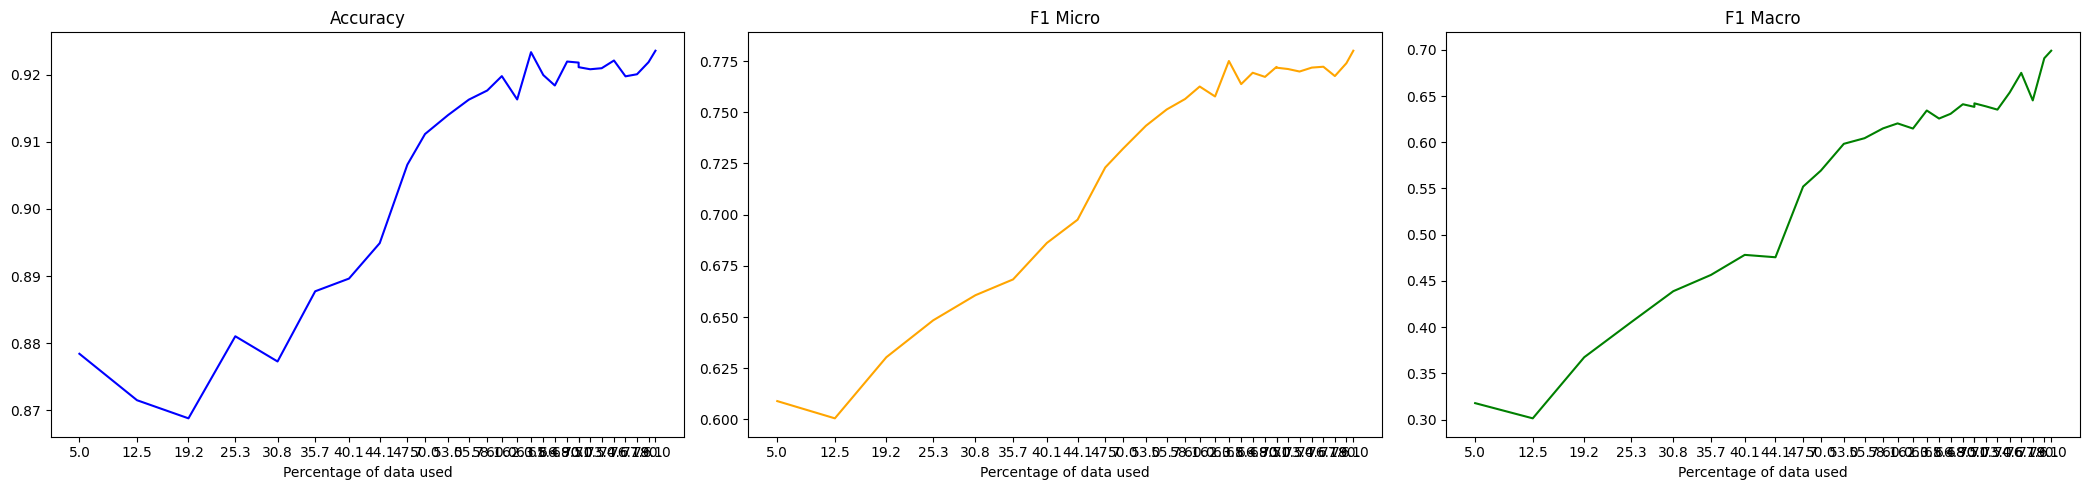

In [ ]:
active_learning(seeds[4], 4)